## Laboratorio #5 Analisis de paquetes de Red


In [3]:
# Lo primero es importar las librerias que necesitamos 

from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import matplotlib.pyplot as plt
import binascii
import seaborn as sns
sns.set(color_codes=True)

In [4]:
# Ahora capturaremos 10 paquetes

num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]


<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:10 UDP:0 ICMP:0 Other:0>


<Ether  dst=9c:b6:d0:19:0b:9f src=74:3a:ef:4a:04:57 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=79 id=39414 flags=DF frag=0 ttl=47 proto=tcp chksum=0x7ce7 src=104.248.10.4 dst=192.168.1.39 |<TCP  sport=https dport=50260 seq=4146186813 ack=1705603657 dataofs=5 reserved=0 flags=PA window=501 chksum=0x641b urgptr=0 |<Raw  load='\x17\x03\x03\x00"K\\xc6\x19tA\\xb6(o\\x89e`\\xfa\n\\xb1/\\x96\\x88B\\xb3g\\xb2\x19\x05\\xa1\\xec5\\xbc\\x8f\\x94\\x8f7\x10\x08\\xa8' |>>>>

In [5]:
a = rdpcap('./analisis_paquetes.pcap')
print(a)

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>


In [6]:
# Ahora uniremos ambos paquetes y procederemos a trabajar con uno solo. 

pac1= pcap 
pac2 = a 

all = pac1 + pac2

wrpcap('combinado.pcap', all)
combi = rdpcap('./combinado.pcap')
print(combi)

<combinado.pcap: TCP:10 UDP:62 ICMP:0 Other:0>


Como podemos ver, ahora ya tenemmos un archivo que cuenta con todos los daros que necesitamos para trabajar, para eso ahora haremos un DataFrame con el archivo. 

In [7]:
# crear un dataframe del archivo: ### --- METODO --- ###

# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(6))

  version ihl tos len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0  79  39414    DF    0   47     6  31975  ...       5   
1       4   5   0  64  39415    DF    0   47     6  31989  ...       5   
2       4   5   0  40  10922    DF    0   64     6  56154  ...       5   
3       4   5   0  40  10923    DF    0   64     6  56153  ...       5   
4       4   5   0  52   6987    DF    0  106     6  60917  ...       8   
5       4   5   0  40  42618    DF    0   64     6  36050  ...       5   

  reserved flags  window chksum urgptr options payload  \
0        0    PA     501  25627      0       0      39   
1        0   FPA     501  25943      0       0      24   
2        0     A     513   6502      0    None       0   
3        0    FA     513   6501      0    None       0   
4        0    SA   65535  53978      0       6       0   
5        0     A     517   4501      0    None       0   

                                         payload_raw  \
0  b'\x17\x03\x03\

Como podemos ya tenemos armado el dataset, con todos los datos que necesitabamos, ahora procederemos a ubicar ciertos valores especificos. 

In [8]:
df[['src','dst','sport','dport', 'payload']]

,src,dst,sport,dport,payload
0,104.248.10.4,192.168.1.39,443,50260,39
1,104.248.10.4,192.168.1.39,443,50260,24
2,192.168.1.39,104.248.10.4,50260,443,0
3,192.168.1.39,104.248.10.4,50260,443,0
4,52.178.17.2,192.168.1.39,443,50565,0
5,192.168.1.39,52.178.17.2,50565,443,0
6,192.168.1.39,52.178.17.2,50565,443,517
7,52.178.17.2,192.168.1.39,443,50566,0
8,192.168.1.39,52.178.17.2,50566,443,0
9,192.168.1.39,52.178.17.2,50566,443,517


In [9]:
#Calcular estadistica del SRC ADDRESS
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Source Address
count               10
unique               3
top       192.168.1.39
freq                 6
Name: src, dtype: object 




In [10]:
#Calcular estadistica del Dst ADDRESS
print("# Top Source Address")
print(df['dst'].describe(),'\n\n')

# Top Source Address
count               10
unique               3
top       192.168.1.39
freq                 4
Name: dst, dtype: object 




In [11]:
#Calcular estadistica del SRC Port
print("# Top Source Address")
print(df['sport'].describe(),'\n\n')

# Top Source Address
count      10
unique      4
top       443
freq        4
Name: sport, dtype: int64 




In [12]:
#Calcular estadistica del Dst Port
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Source Address
count               10
unique               3
top       192.168.1.39
freq                 6
Name: src, dtype: object 




#### Estadisticas

In [13]:
#¿Quien es la IP de origen mas frecuente?
frequent_address = df['src'].describe()['top']
print(frequent_address)

192.168.1.39


In [14]:
# A que IPs destino mas frecuente
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

['104.248.10.4' '52.178.17.2'] 




In [15]:
# Cual es la IP que se comunica mas la primera IP
print(df[df['dst'] == frequent_address]['src'].unique(),"\n\n")

['104.248.10.4' '52.178.17.2'] 




In [16]:
fd_df = df[df["src"] == frequent_address]
print("IPs a las que mas se comunica: ", fd_df["dst"].unique())
print("Puertos destinos a las que se comunica: ", fd_df["sport"].unique())

IPs a las que mas se comunica:  ['104.248.10.4' '52.178.17.2']
Puertos destinos a las que se comunica:  [50260 50565 50566]


#### Indique el propósito de los puertos que más aparece en los incisos d y e
Esto es por el DNS, es la funcionalidad del DNS lo que hace que estos puertos aparezcan.

### GRAFICAS
######  Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

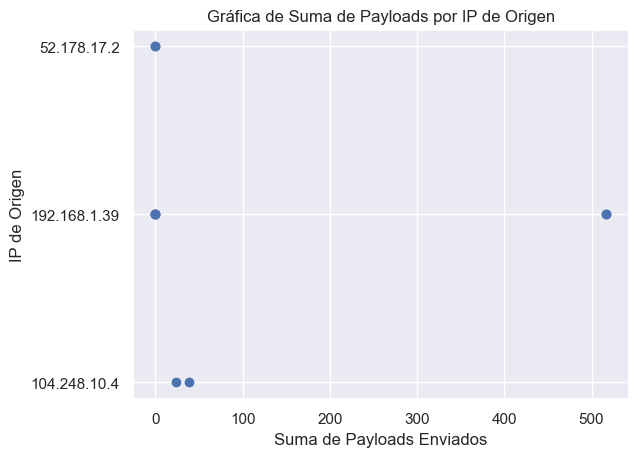

In [17]:
ips = df['src']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('IP de Origen')
plt.title('Gráfica de Suma de Payloads por IP de Origen')
plt.show()

###### Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

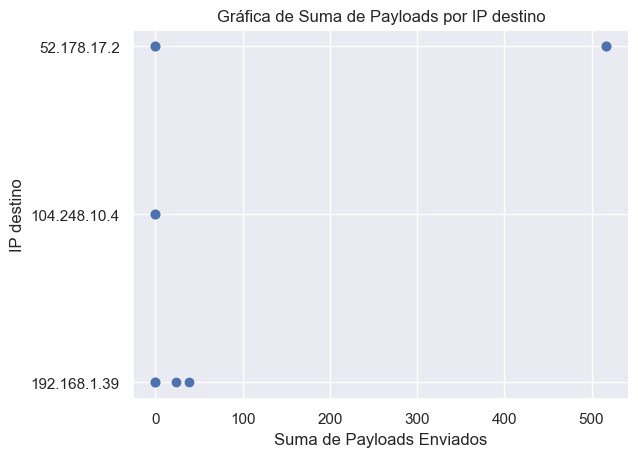

In [18]:
ips = df['dst']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('IP destino')
plt.title('Gráfica de Suma de Payloads por IP destino')
plt.show()

######  Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

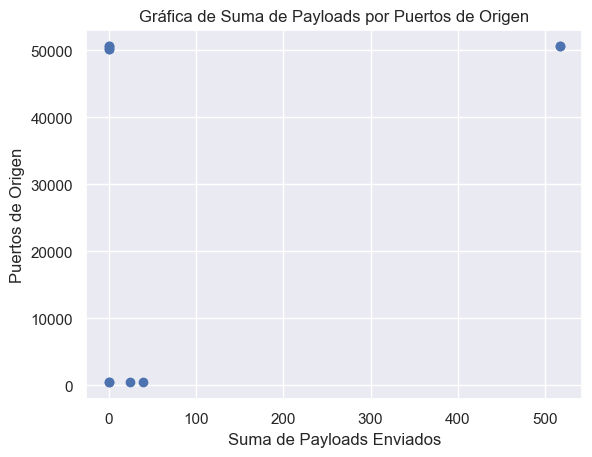

In [19]:
prto = df['sport']
pay = df['payload']

plt.scatter(pay, prto)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('Puertos de Origen')
plt.title('Gráfica de Suma de Payloads por Puertos de Origen')
plt.show()

######  Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos.

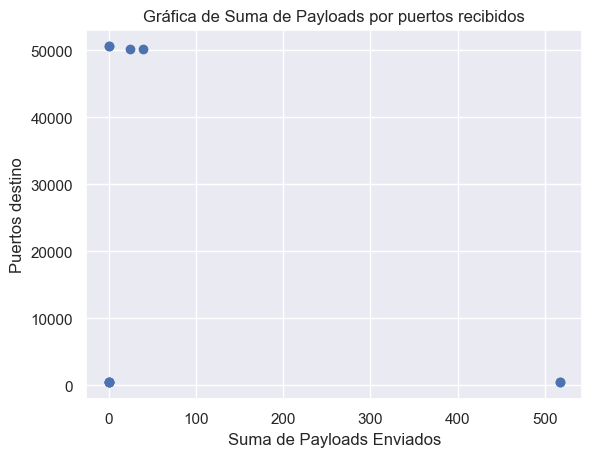

In [20]:
ips = df['dport']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('Puertos destino')
plt.title('Gráfica de Suma de Payloads por puertos recibidos')
plt.show()

##### Por ultimo, haremos una investigacion del payload

In [28]:
fil_df = df[df["src"] == frequent_address]
len(fil_df)

6

In [29]:
pay_fil = fil_df["payload"].unique()
max(pay_fil)

517

In [30]:
fil_df[fil_df["payload"] == max(pay_fil)]

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
6,4,5,0,557,42619,DF,0,64,6,35532,...,5,0,PA,517,31025,0,0,517,b'\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...,b'1603010200010001fc0303c86bb2e7194d870b82961f...
9,4,5,0,557,42621,DF,0,64,6,35530,...,5,0,PA,517,26386,0,0,517,"b""\x16\x03\x01\x02\x00\x01\x00\x01\xfc\x03\x03...",b'1603010200010001fc0303b9c7f0ae625cce564786f3...
